In [1]:
%cd ..

D:\SoftUni\Machine Learning\mushrooms project


In [2]:
# Imports
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import CategoricalNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, accuracy_score, recall_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.model_selection import cross_validate

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

from src import functions

In [3]:
RANDOM_SEED = 11

# Identification of toxic mushrooms using Machine Learning

### Abstarct

The purpose of this project is to explore the applicability of supervised ML approach to identify toxic mushrooms. A classification, based on various features of fungi, belonging to Agaricaceae family, is applied. Most of these are physical characteristics of the mushrooms, describing their cap, stalk, gill, spore and smell, along with other that describe their habitat and population. The project aims to obtain correct approximators for solving the task. As a result of modeling and EDA, the most important mushroom's features, which can be used to determine the poisonous samples, are also identified.

### Introduction and background of the problem

The question of how to distinguish between edible and toxic mushrooms is of great importance when it comes to the people who consume or cultivate them. And there is not a simple answer to it. It could be said that in order to answer the question if some mushroom is poisonous or not, it's species must be identified first. The identification is done by using the characteristics of the fungus. Since the Fungi Kingdom follows the general biology taxonomic classification system, based on shared characteristics, it should be noted, that the fungi of interest of this study belong to species of Agaricus [[2]](#references) and Lepiota [[3]](#references) genera, Agaricaceae family of Basidiomycota divison. These are traditional shaped mushrooms that have a cap, stem, gills and spores. The most famous species among them is Agaricus bisporus, commonly known as cultivated mushroom.

It can be assumed that, similar to the hierarchical division of mushrooms by their common characteristics, some of their features could be used as a guideline in determining them into edible or toxic. According to this assumption, some characteristics may be more specific to the poisonous or to the edible species of the studied genera. Тhe hypothesis of this project assumes that the data which describe such species can be modelled using classification ML algorithms to learn patterns and relationships between different fungi's features.

This classification task is not new to the field of Machine Learning and Neural Networks. Тwo approaches have been applied. The most used one rely on features that people manually label and uses primarily traditional ML techniques. That is the case with the current project. The other approach uses Deep Learning methods and Computer Vision. It involves usage of Convolutional NN like ResNet - 50, AlexNet and GoogLeNet. [[4]](#references) 

As stated above, this project relies on traditional ML approach. It uses Supervised learning to train classification algorithms with labeled data. Very few datasets, containing structured data of mushroom characteristics, could be found on the web. I discovered three, two of which was generated based on the first(original) one. Respective, the related studies use the same data source or its derivatives. Several articles describing experiments that have been performed previously with ML approach exist. Some researchers use basic algorithms like Decision Tree and Logistic Regression [[5]](#references), while other also take advantage of ensembles like Random Forest [[6]](#references) or nonparametric classifiers such as K - Nearest Neighbors. [[7]](#references) Although acieving high scores of evaluation metrics like accuracy, precission and recall, these studies need more in - depth EDA in order to support the ML process with insights and to justify the transformations necessary to make the data suitable for modeling. There are also various projects on this topic in Kaggle. [[8]](#references) They extend the experiments using Naive Bayes, Support Vector Machines and XGBoost algorithms. Like in the articles, the researchers achieve high scores on evaluation metrics but most of them lack analysis of results, suitable preprocessing, EDA or hyperparameter optimization. Тhis project aims to takе into account the strengths and weaknesses of the explored studies, taking the useful information and filling the gaps. 

### Dataset information and EDA

The used dataset [[9]](#references) includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota genera. It is donated to "UCI Machine Learning Repository" by Jeff Schlimmer. The records are drawn from "The Audubon Society Field Guide to North American Mushrooms (1981)". Each species is identified as definitely edible, definitely poisonous, or of unknown edibility and not recommended. Detailed information is provided by the authors in a "data/agaricus-lepiota.names" file. [[1]](#references) The latter class is combined with the poisonous one. Some species of these two genera are among the most popular and cultivated mushrooms worldwide. 

In [4]:
mushrooms_data = pd.read_csv('data/agaricus-lepiota.data', header = None)

In [5]:
mushrooms_data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,e,k,s,n,f,n,a,c,b,y,e,?,s,s,o,o,p,o,o,p,b,c,l
8120,e,x,s,n,f,n,a,c,b,y,e,?,s,s,o,o,p,n,o,p,b,v,l
8121,e,f,s,n,f,n,a,c,b,n,e,?,s,s,o,o,p,o,o,p,b,c,l
8122,p,k,y,n,f,y,f,c,n,b,t,?,s,k,w,w,p,w,o,e,w,v,l


The dataframe does not have a header, but the column names are provided in the cited above file. I will add them for clarity.   

In [6]:
full_col_names = {
    0: 'label',
    1: 'cap_shape',
    2: 'cap_surface',
    3: 'cap_color',
    4: 'bruises',
    5: 'odor',
    6: 'gill_attachment',
    7: 'gill_spacing',
    8: 'gill_size',
    9: 'gill_color',
    10: 'stalk_shape',
    11: 'stalk_root',
    12: 'stalk_surface_above_ring',
    13: 'stalk_surface_below_ring',
    14: 'stalk_color_above_ring',
    15: 'stalk_color_below_ring',
    16: 'veil_type',
    17: 'veil_color',
    18: 'ring_number',
    19: 'ring_type',
    20: 'spore_print_color',
    21: 'population',
    22: 'habitat'
}

In [7]:
mushrooms_data.rename(columns = full_col_names, inplace = True)

In [8]:
mushrooms_data

,label,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,stalk_shape,stalk_root,stalk_surface_above_ring,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,e,k,s,n,f,n,a,c,b,y,e,?,s,s,o,o,p,o,o,p,b,c,l
8120,e,x,s,n,f,n,a,c,b,y,e,?,s,s,o,o,p,n,o,p,b,v,l
8121,e,f,s,n,f,n,a,c,b,n,e,?,s,s,o,o,p,o,o,p,b,c,l
8122,p,k,y,n,f,y,f,c,n,b,t,?,s,k,w,w,p,w,o,e,w,v,l


The attribute values are replaced with suitable one - character acronymns. Corresponding full - named values are also provided in "data/agaricus-lepiota.names" file. [[1]](#references). The values of the target variable - "label" - are in the first column. They are either "p"(poisonous) or "e"(edible).

![general_morphology_agaricus](../images/general_morphology_agaricus.png) |
-

The mushroom parts of interest are cap, gill, ring, stalk, veil and spores. They are measured in several dimensions and can be seen at the diagram above. Other characteristics taken into account are habitat, odor, population and bruising. Although the aim of this study is to train a model to distinguish between the two classes based on these features, it is stated that there is no simple rule for determining the edibility of a mushroom.

In [9]:
mushrooms_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   label                     8124 non-null   object
 1   cap_shape                 8124 non-null   object
 2   cap_surface               8124 non-null   object
 3   cap_color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill_attachment           8124 non-null   object
 7   gill_spacing              8124 non-null   object
 8   gill_size                 8124 non-null   object
 9   gill_color                8124 non-null   object
 10  stalk_shape               8124 non-null   object
 11  stalk_root                8124 non-null   object
 12  stalk_surface_above_ring  8124 non-null   object
 13  stalk_surface_below_ring  8124 non-null   object
 14  stalk_color_above_ring  

The dataframe contains 8124 records and 23 columns - 22 of features and one of the target variable.

All feature values have 'object' data type.

In [10]:
mushrooms_data.duplicated().unique()

array([False])

The dataset don't contain any duplicated records.

In [11]:
mushrooms_data['label'].value_counts(normalize = True) * 100

label
e    51.797144
p    48.202856
Name: proportion, dtype: float64

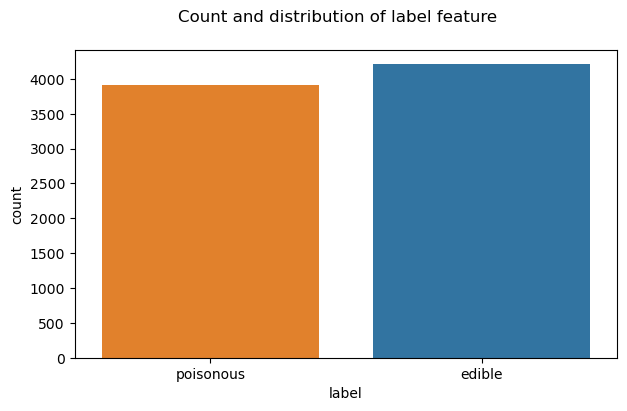

In [12]:
fig, axes = plt.subplots(1, 1, figsize = (7, 4))

sns.countplot(data = mushrooms_data, x = 'label', hue = 'label', palette = ['tab:orange', 'tab:blue'], legend = False)

axes.set_xticks([0, 1])
axes.set_xticklabels(['poisonous', 'edible'])
fig.suptitle('Count and distribution of label feature')

plt.show()

The distribution of classes of target variable in the whole dataset is almost equal - 52 % edible and 48 % poisonous. It is not imbalanced w.r.t. the classification tasks.

In [13]:
mushrooms_data.nunique()

label                        2
cap_shape                    6
cap_surface                  4
cap_color                   10
bruises                      2
odor                         9
gill_attachment              2
gill_spacing                 2
gill_size                    2
gill_color                  12
stalk_shape                  2
stalk_root                   5
stalk_surface_above_ring     4
stalk_surface_below_ring     4
stalk_color_above_ring       9
stalk_color_below_ring       9
veil_type                    1
veil_color                   4
ring_number                  3
ring_type                    5
spore_print_color            9
population                   6
habitat                      7
dtype: int64

In [14]:
mushrooms_data['veil_type'].unique()

array(['p'], dtype=object)

There are one feature with a single value of all observations. All 'veil_type' values are equal to "p"(partial). Since it not add any valuble information I will drop that column. It is reasonable to do this in a data pipeline with the other preprocessing. I will do it now, to prevent warnings and empty rows and columns on a association heatmap.

In [15]:
mushrooms_data.drop(columns = 'veil_type', inplace = True)

In [16]:
mushrooms_data.shape

(8124, 22)

It seems that there are not any missing values since every column has 8124 non - null values. But in the description in "data/agaricus-lepiota.names" file [[1]](#references) is stated that 2480 values of attribute #11(stalk_root) are missing. They are denoted by "?", as can be seen at the last rows of the dataframe above.

In [17]:
mushrooms_data.loc[mushrooms_data['stalk_root'] == '?']['label'].value_counts(normalize = True) * 100

label
p    70.967742
e    29.032258
Name: proportion, dtype: float64

In [18]:
mushrooms_data.loc[mushrooms_data['stalk_root'] != '?']['label'].value_counts(normalize = True) * 100

label
e    61.800142
p    38.199858
Name: proportion, dtype: float64

When the data is separated on two subsets - with and without missing 'stalk_root' values, the distribution changes significantly. The observations where 'stalk_root' value is missing have 71 % "poisonous" labels. On the other hand, the subset without missing 'stalk_root' values have 62 % "edible" labels. It seems that most of the records with missing values are 'poisonous' labeled.

In [19]:
mushrooms_data.tail(2480)['stalk_root'].value_counts()

stalk_root
?    2177
b     259
c      44
Name: count, dtype: int64

The observations with missing values are concentrated in the bottom part of the dataset. 2177 of all 2480 are within last 2480 records. Maybe the occurences of missing 'stalk_root' values are not completely at random. 

#### Data visualization and insights

Crosstabs and countplots are used in order to show the categorical frequency distributions of the features.

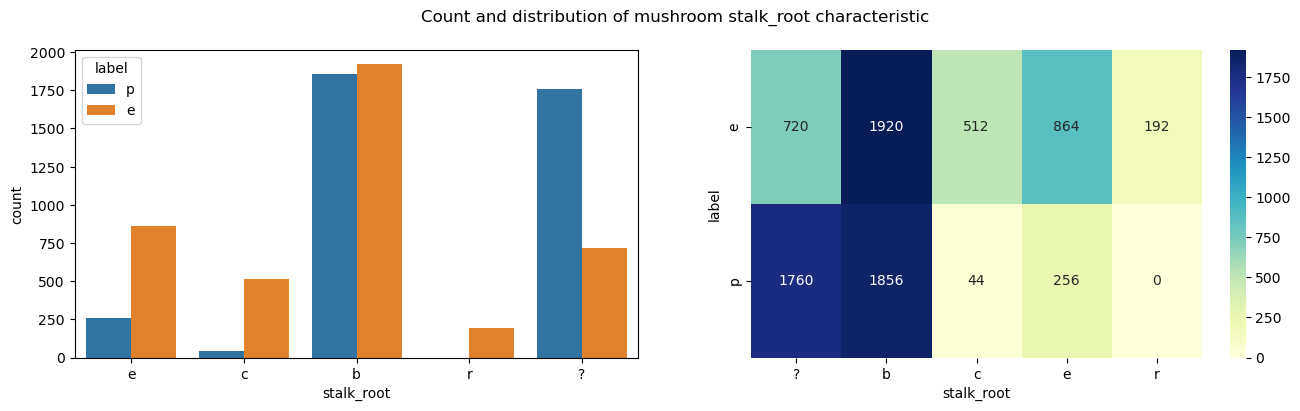

In [20]:
fig, axes = plt.subplots(1, 2, figsize = (16, 4))

sns.countplot(ax = axes[0], data = mushrooms_data, x = 'stalk_root', hue = 'label')
sns.heatmap(pd.crosstab(mushrooms_data['label'], mushrooms_data['stalk_root']), ax = axes[1], annot = True, fmt = 'd', cmap = 'YlGnBu')

fig.suptitle('Count and distribution of mushroom stalk_root characteristic')

plt.show()

The second most frequent category of "stalk_root" feature is the missing one lebeled with "?". It represents about 30 percent of the records, so ignoring them is not an option, since it will reduce the amount of data significantly. Dropping the column can lead to loss of valuable information with respect to predicting if mushroom is poisinous or not. It will be appropriate to fill the missing values using imputation technique. The mode imputation can lead to overrepresentation of the most frequent "bulbous" category, which represents 46 percent of all records. Another method for imputation of missing value is to ose KNN, but it is not ideal in that situation since all feature values are categorical and have to be converted to numerical before using the algorithm. At the other hand, the reason because significant part of "stalk_root" values are missing may be because that part is not collected during the harvest. This could be the case in the new data, so it will be appropriate to leave 'missing' values as a separate category of this feature. Another approach is to use ML algorithm to predict the "stalk_root" category of the records where it is missing.

Aside from the "missing data" topic, the most common "stalk root" type is "b"(bulbous) and the label classes are evenly distributed within. The "r"(rooted) type contains only edible mushrooms, but it should be noted that these observations are relatively few in number.

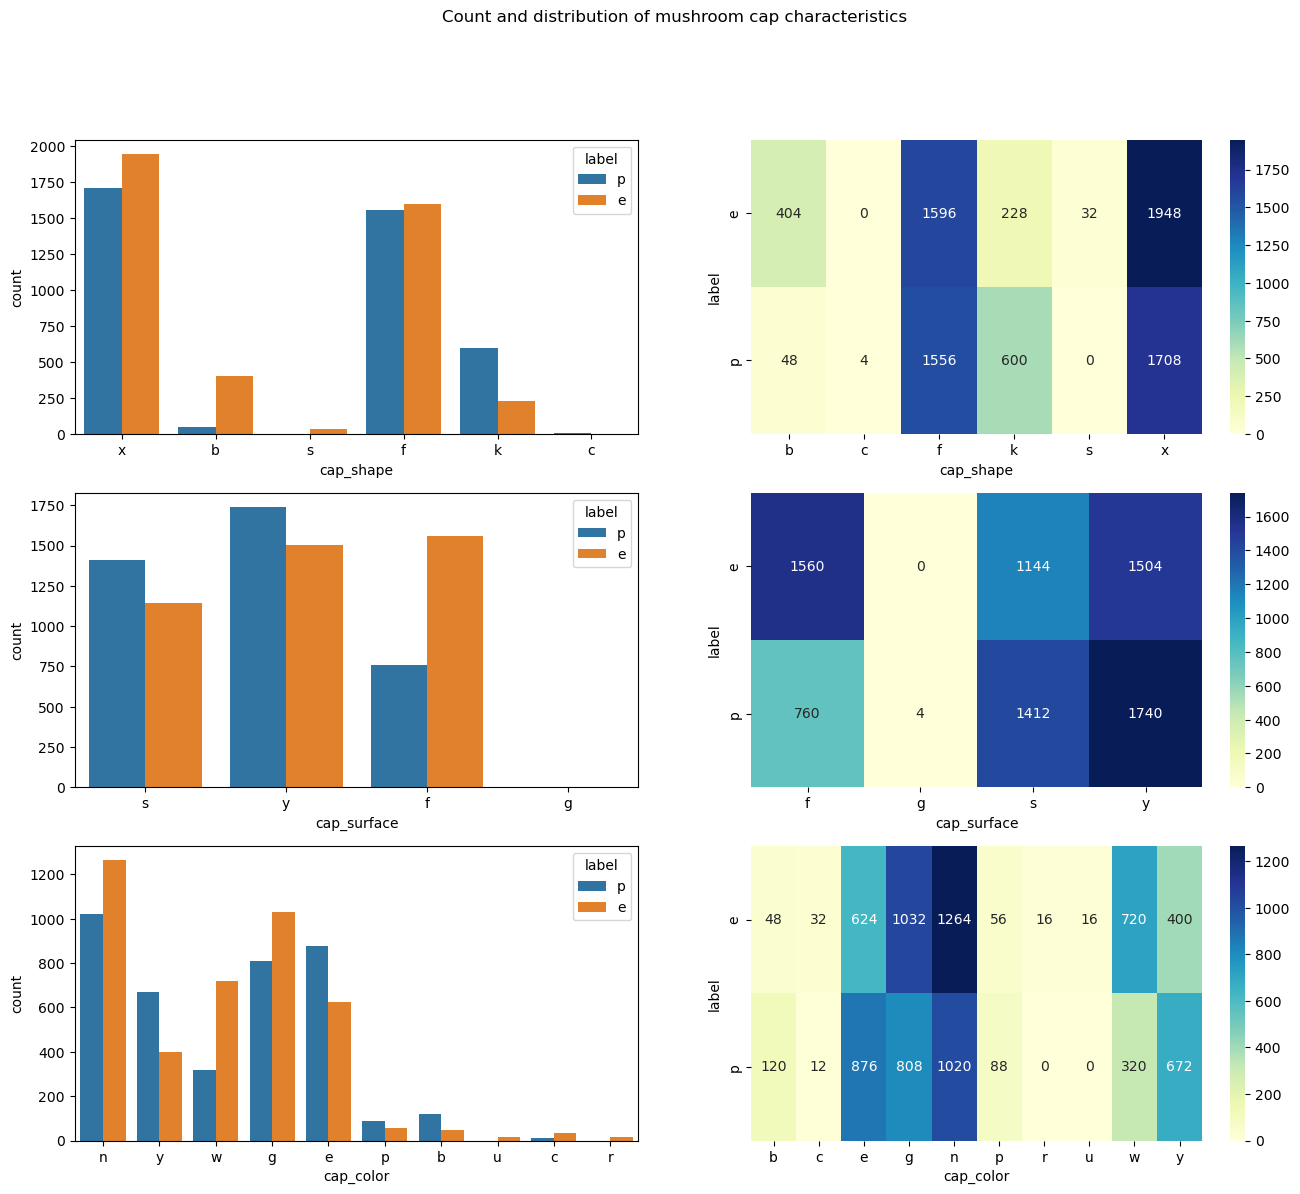

In [21]:
fig, axes = plt.subplots(3, 2, figsize = (16, 13))

sns.countplot(ax = axes[0, 0], data = mushrooms_data, x = 'cap_shape', hue = 'label')
sns.heatmap(pd.crosstab(mushrooms_data['label'], mushrooms_data['cap_shape']), ax = axes[0, 1], annot = True, fmt = 'd', cmap = 'YlGnBu')
sns.countplot(ax = axes[1, 0], data = mushrooms_data, x = 'cap_surface', hue = 'label')
sns.heatmap(pd.crosstab(mushrooms_data['label'], mushrooms_data['cap_surface']), ax = axes[1, 1], annot = True, fmt = 'd', cmap = 'YlGnBu')
sns.countplot(ax = axes[2, 0], data = mushrooms_data, x = 'cap_color', hue = 'label')
sns.heatmap(pd.crosstab(mushrooms_data['label'], mushrooms_data['cap_color']), ax = axes[2, 1], annot = True, fmt = 'd', cmap = 'YlGnBu')

fig.suptitle('Count and distribution of mushroom cap characteristics')

plt.show()

The data contains samples of mushrooms with six different cap shapes. Most of them are in 'convex'(x) and 'flat'(f) categories. It is noticeable that "sunken"(s) and "convex"(c) are very few in number - 32 and 4. They can be problematic w.r.t. splitting the dataset for test and validation purposes, especially the last one.

Cap surfaces of all samples are roughly evenly distributed between "scaly"(y), "smooth"(s) and "fibrous"(f) categories. There is one more - "grooves"(g), but it has only four observations - yet anotother problematic category w.r.t. to splitting and encoding.

Cap color feature has ten unique categories. "Brown"(n), "gray"(g), "red"(e), "white"(w) and "yellow"(y) are the most frequent among them. From the others, "purple"(u) and "green"(r) are very rare with only 16 observations each. Tha last ones has only "edible" labels but this cannot lead to a conclusion because of the small number.

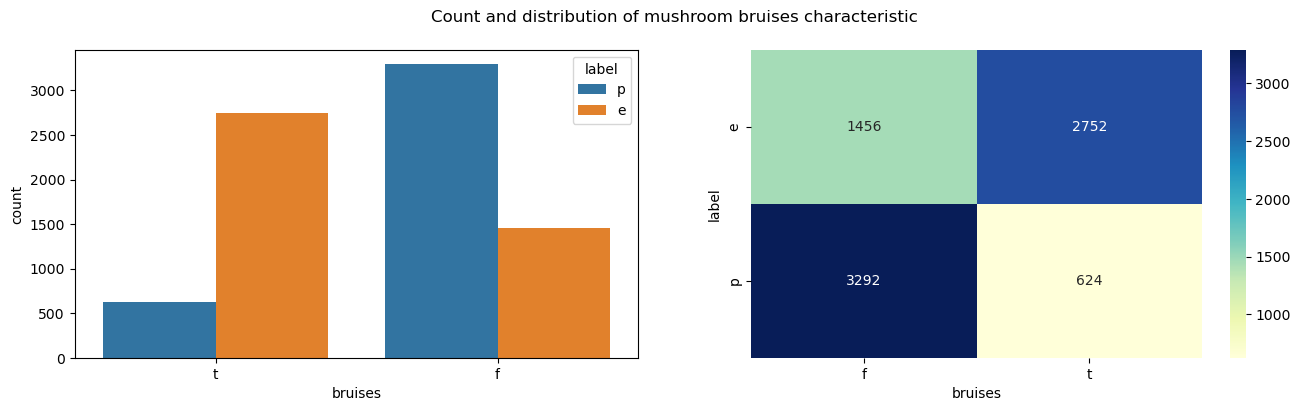

In [22]:
fig, axes = plt.subplots(1, 2, figsize = (16, 4))

sns.countplot(ax = axes[0], data = mushrooms_data, x = 'bruises', hue = 'label')
sns.heatmap(pd.crosstab(mushrooms_data['label'], mushrooms_data['bruises']), ax = axes[1], annot = True, fmt = 'd', cmap = 'YlGnBu')

fig.suptitle('Count and distribution of mushroom bruises characteristic')

plt.show()

Bruising is a change of the color of a mushroom. Just over a half of the records don't develop bruices("f" category). It is moticeable that over 80 percent from the others("t" category) are of edible mushrooms.

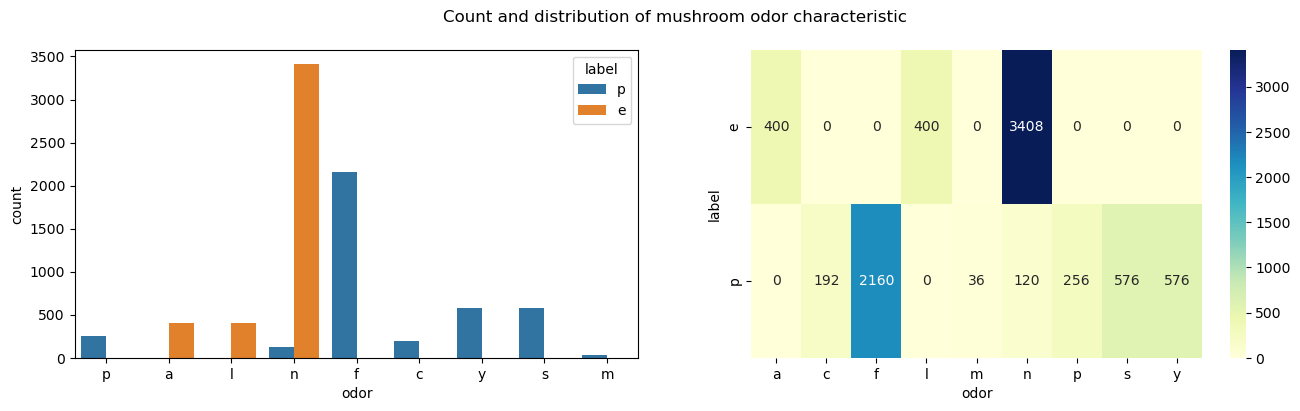

In [23]:
fig, axes = plt.subplots(1, 2, figsize = (16, 4))

sns.countplot(ax = axes[0], data = mushrooms_data, x = 'odor', hue = 'label')
sns.heatmap(pd.crosstab(mushrooms_data['label'], mushrooms_data['odor']), ax = axes[1], annot = True, fmt = 'd', cmap = 'YlGnBu')

fig.suptitle('Count and distribution of mushroom odor characteristic')

plt.show()

Odor feature has nine different categories.The most frequent one(3528 reccords) is "none"(n) indicating mushrooms without odor. About 97 percent of them are of edible mushrooms! The second most frequent category is "foul"(f) and has 2160 reccords, all with poisonous label! The other categories also contain observations of only edible or only poisonous mushrooms. This feature seems to be very important to the classification task of the project.

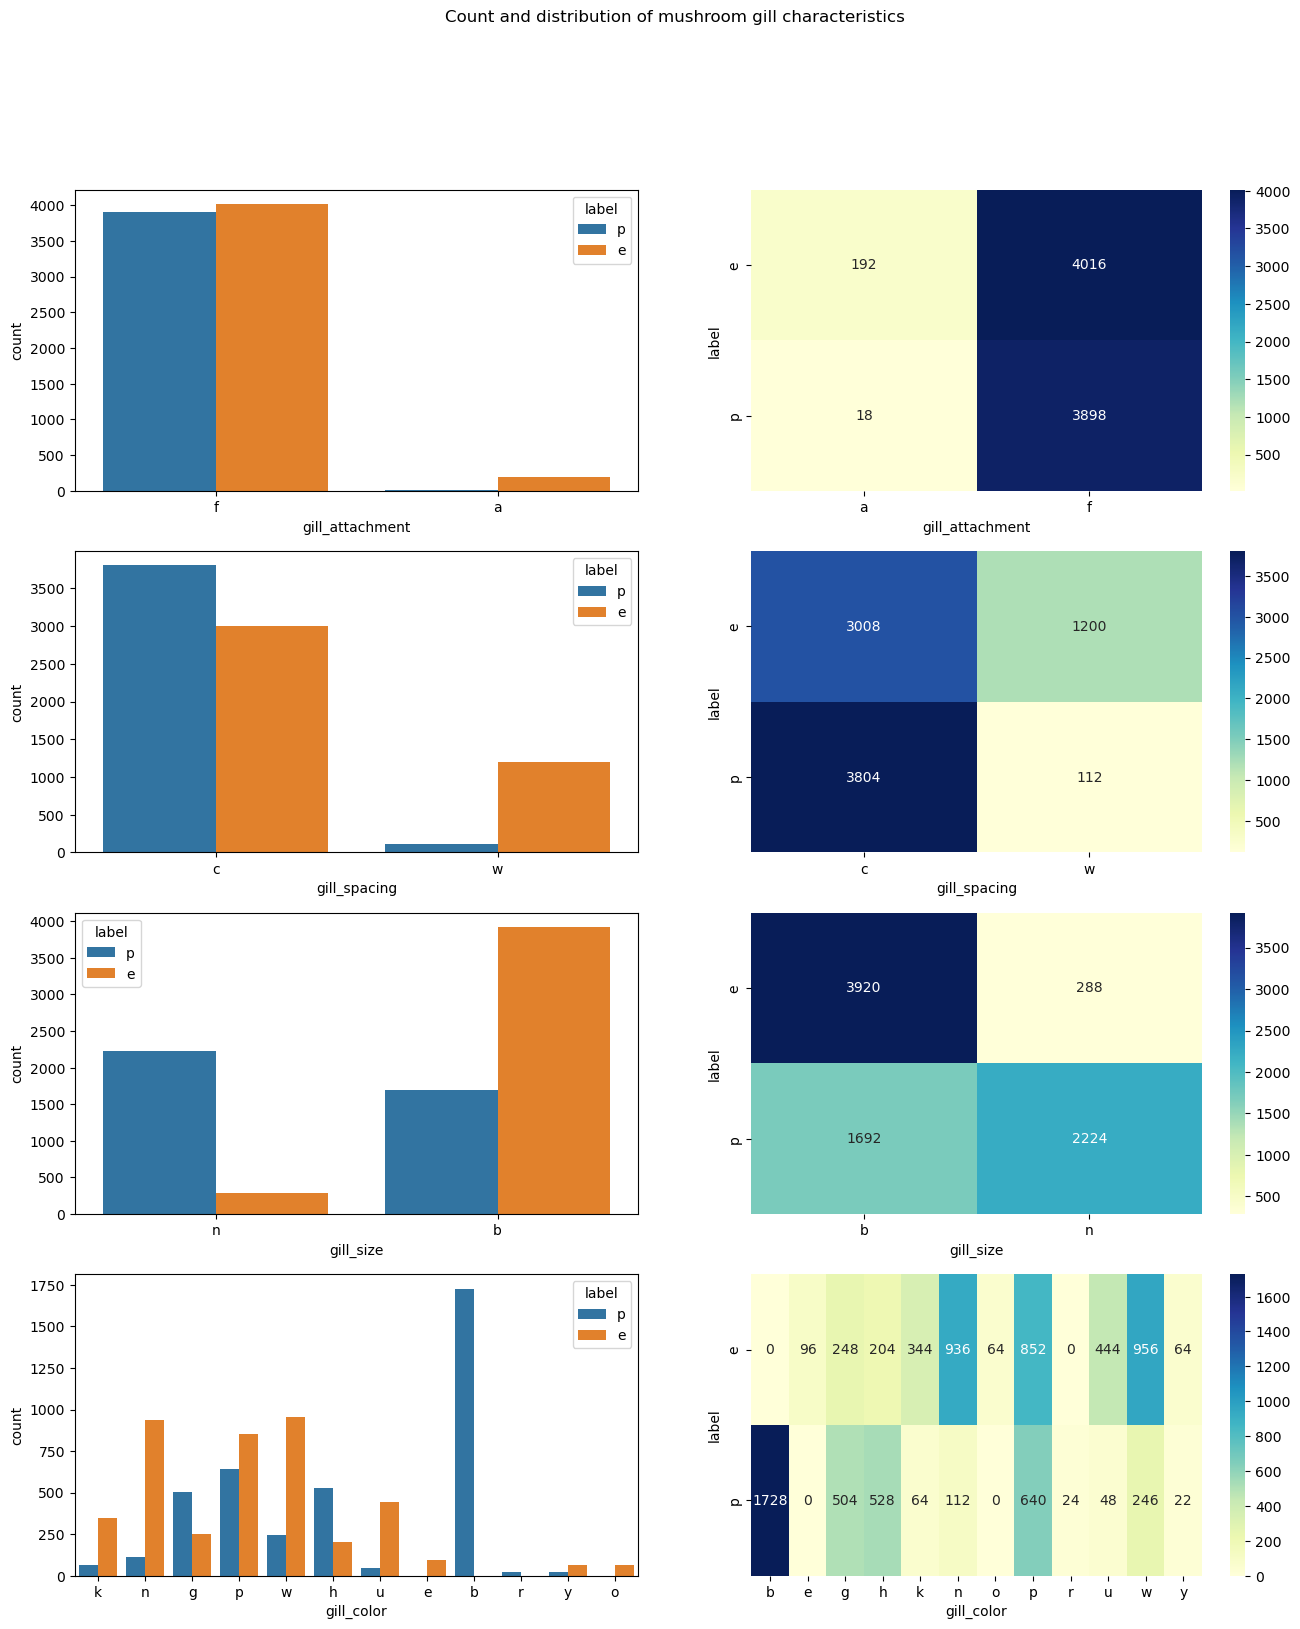

In [24]:
fig, axes = plt.subplots(4, 2, figsize = (16, 18))

sns.countplot(ax = axes[0, 0], data = mushrooms_data, x = 'gill_attachment', hue = 'label')
sns.heatmap(pd.crosstab(mushrooms_data['label'], mushrooms_data['gill_attachment']), ax = axes[0, 1], annot = True, fmt = 'd', cmap = 'YlGnBu')
sns.countplot(ax = axes[1, 0], data = mushrooms_data, x = 'gill_spacing', hue = 'label')
sns.heatmap(pd.crosstab(mushrooms_data['label'], mushrooms_data['gill_spacing']), ax = axes[1, 1], annot = True, fmt = 'd', cmap = 'YlGnBu')
sns.countplot(ax = axes[2, 0], data = mushrooms_data, x = 'gill_size', hue = 'label')
sns.heatmap(pd.crosstab(mushrooms_data['label'], mushrooms_data['gill_size']), ax = axes[2, 1], annot = True, fmt = 'd', cmap = 'YlGnBu')
sns.countplot(ax = axes[3, 0], data = mushrooms_data, x = 'gill_color', hue = 'label')
sns.heatmap(pd.crosstab(mushrooms_data['label'], mushrooms_data['gill_color']), ax = axes[3, 1], annot = True, fmt = 'd', cmap = 'YlGnBu')

fig.suptitle('Count and distribution of mushroom gill characteristics')

plt.show()

Gill attachment, spacing and size are binary features. 

Almost all of "gill_attachment" records are in "free"(f) category and are evenly distributed between target variable labels. The rest about 200 records has "attached"(a) category.

Over 80 percent of "gill_spacing" values fall into "close"(c) category. The other 1312 are in "crowded"(w) category from which more than 90 percent have "edible" label. 

Gill sizes are "broad"(b) and "narrow"(n). The last ones are 2512 records, 88 percent of which have "poisonous" label.

Gill colors are spread across 12 categories. The most frequent color is "buff"(b) with 1728 records. Seems that all mushrooms with this color in the dataset are poisonous!

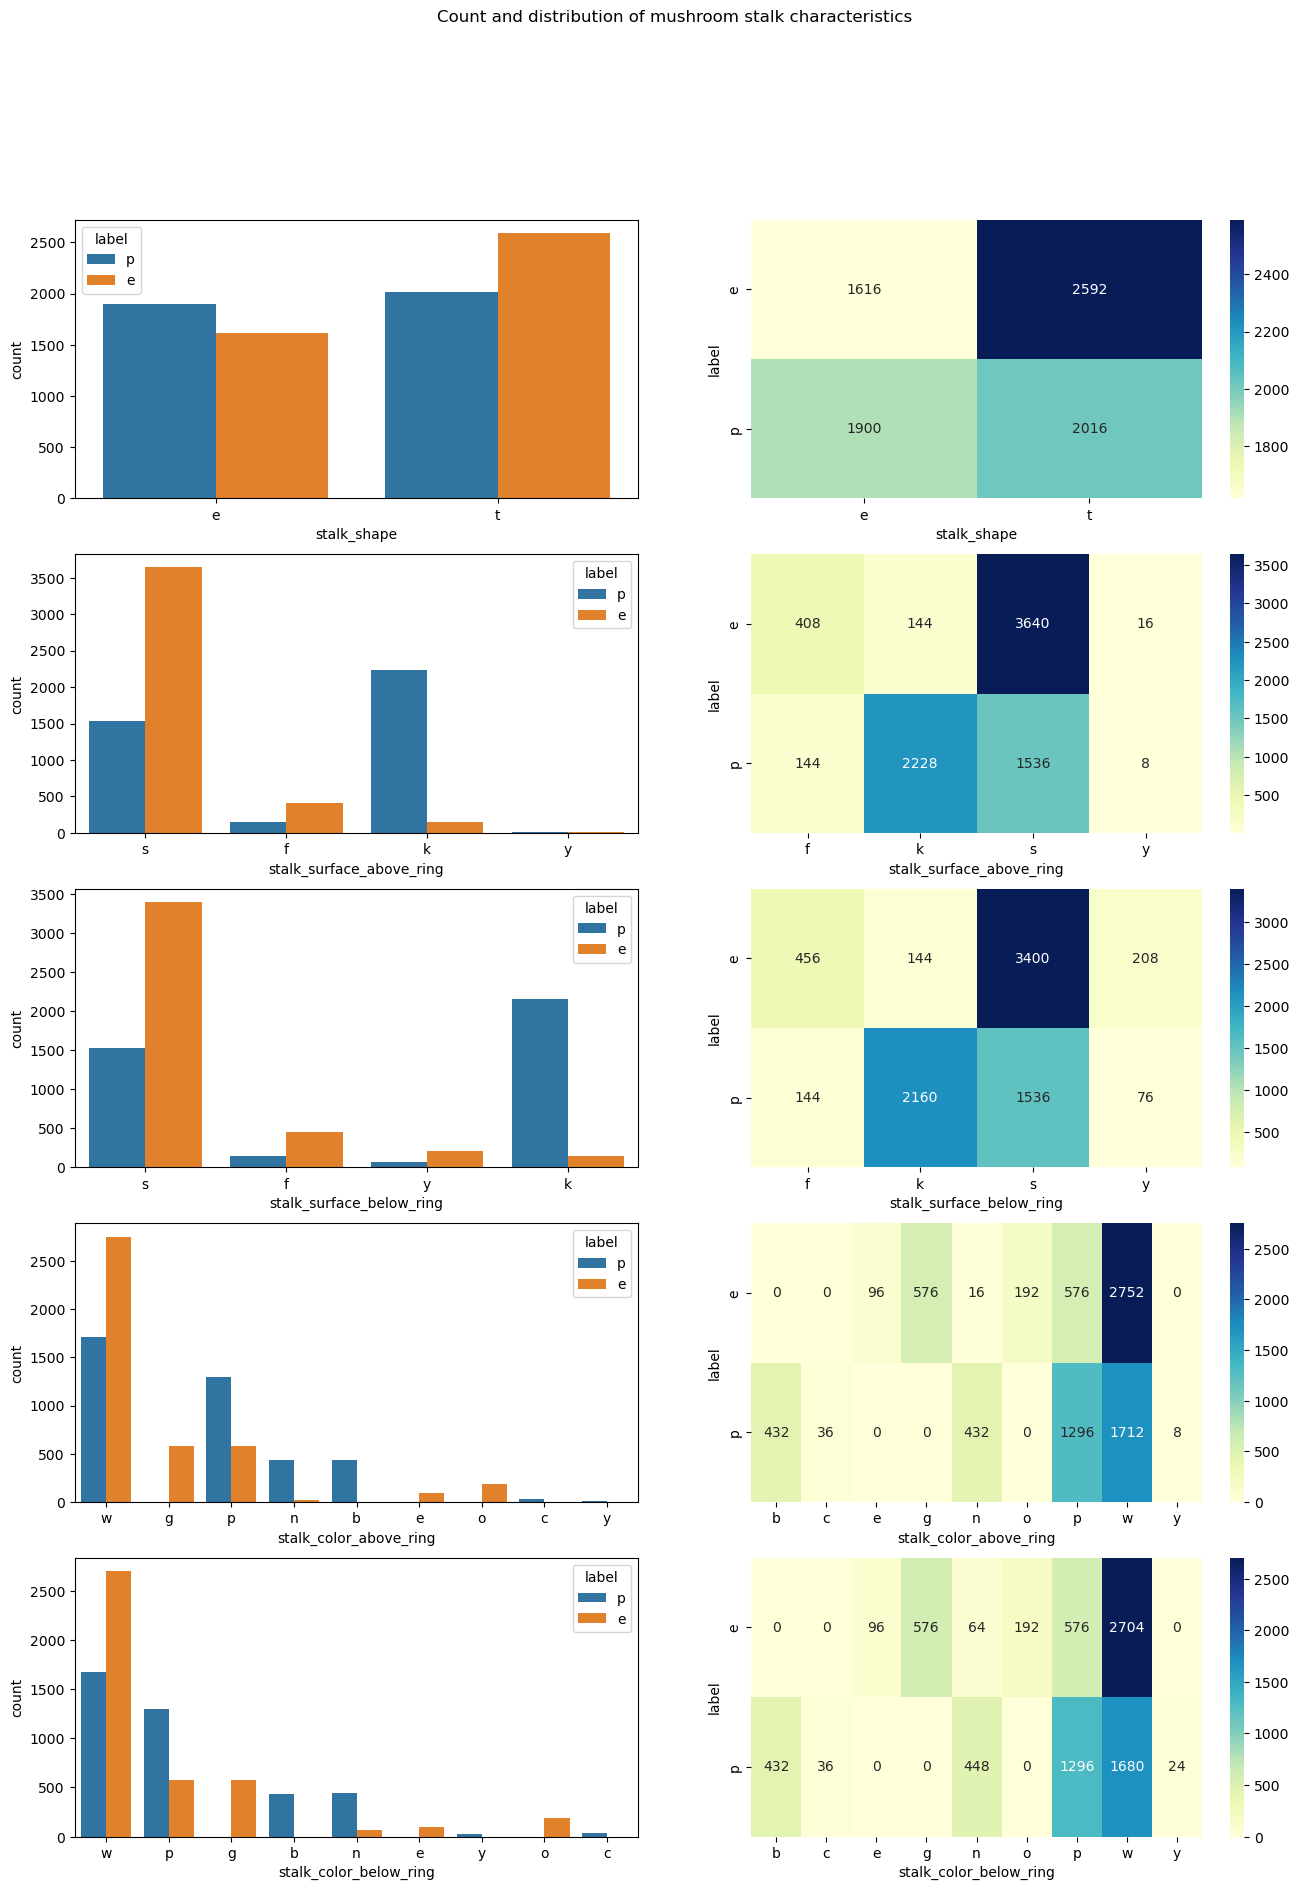

In [25]:
fig, axes = plt.subplots(5, 2, figsize = (16, 21))

sns.countplot(ax = axes[0, 0], data = mushrooms_data, x = 'stalk_shape', hue = 'label')
sns.heatmap(pd.crosstab(mushrooms_data['label'], mushrooms_data['stalk_shape']), ax = axes[0, 1], annot = True, fmt = 'd', cmap = 'YlGnBu')
sns.countplot(ax = axes[1, 0], data = mushrooms_data, x = 'stalk_surface_above_ring', hue = 'label')
sns.heatmap(pd.crosstab(mushrooms_data['label'], mushrooms_data['stalk_surface_above_ring']), ax = axes[1, 1], annot = True, fmt = 'd', cmap = 'YlGnBu')
sns.countplot(ax = axes[2, 0], data = mushrooms_data, x = 'stalk_surface_below_ring', hue = 'label')
sns.heatmap(pd.crosstab(mushrooms_data['label'], mushrooms_data['stalk_surface_below_ring']), ax = axes[2, 1], annot = True, fmt = 'd', cmap = 'YlGnBu')
sns.countplot(ax = axes[3, 0], data = mushrooms_data, x = 'stalk_color_above_ring', hue = 'label')
sns.heatmap(pd.crosstab(mushrooms_data['label'], mushrooms_data['stalk_color_above_ring']), ax = axes[3, 1], annot = True, fmt = 'd', cmap = 'YlGnBu')
sns.countplot(ax = axes[4, 0], data = mushrooms_data, x = 'stalk_color_below_ring', hue = 'label')
sns.heatmap(pd.crosstab(mushrooms_data['label'], mushrooms_data['stalk_color_below_ring']), ax = axes[4, 1], annot = True, fmt = 'd', cmap = 'YlGnBu')

fig.suptitle('Count and distribution of mushroom stalk characteristics')

plt.show()

Stalk shapes of the species are either enlarging("e") or tapering("t"). Enlarging prevails. The distribution of target variable within both categories is roughly equal.

The surface of the mushroom's stalk is characterized by two features: "stalk_surface_above_ring" and "stalk_surface_below_ring". Both have same categories: fibrous("f"), scaly("y"), silky("k") and smooth("s"). Although they are different features, the distribution of data across their categories is very similar. Also, the distribution of target variable within corresponding categories of both features is approximately equal. Thus, both will add almost equal information to a ML model an I will drop one of them. Тhis dimensionality reduction will favor the encoding of the data, as needed to feed scikit-learn algorithms.

The stalk color also is characterized by two features: "stalk_scolor_above_ring" and "stalk_color_below_ring". They have same categories: brown("n"), buff("b"), cinnamon("c"), gray("g"), orange("o"), pink("p"), red("e"), white("w") and yellow("y"). Similary to "stalk_surface" features, the distribution of data across them is roughly equal. Again, for the same reason, I will drop one of them.

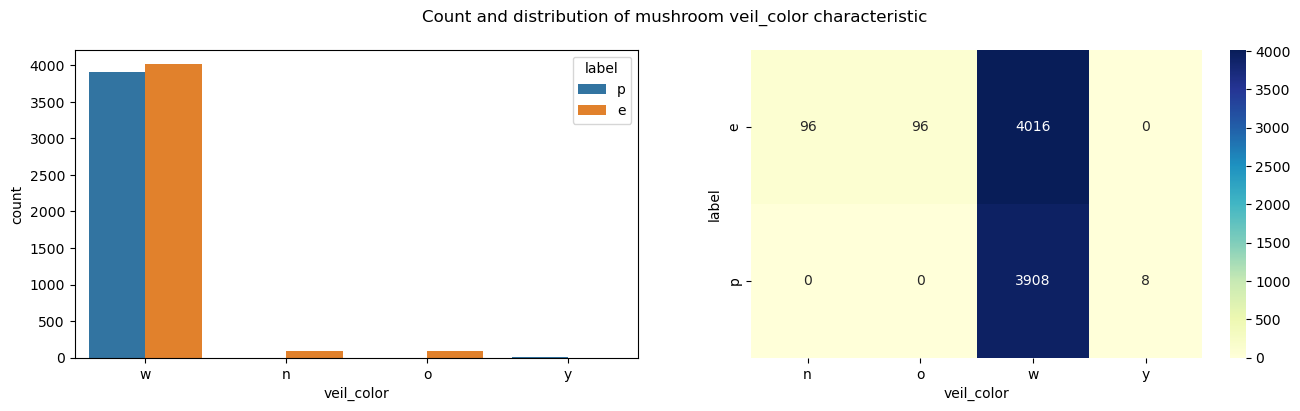

In [26]:
fig, axes = plt.subplots(1, 2, figsize = (16, 4))

sns.countplot(ax = axes[0], data = mushrooms_data, x = 'veil_color', hue = 'label')
sns.heatmap(pd.crosstab(mushrooms_data['label'], mushrooms_data['veil_color']), ax = axes[1], annot = True, fmt = 'd', cmap = 'YlGnBu')

fig.suptitle('Count and distribution of mushroom veil_color characteristic')

plt.show()

Almost all of "veil_color" observations are white("w") and the target variable labels are evenly distributed within. Brown("n") and orange("o") are edible, but both categories have only 96 records. There are only eight observations of yellow("y") veil color.

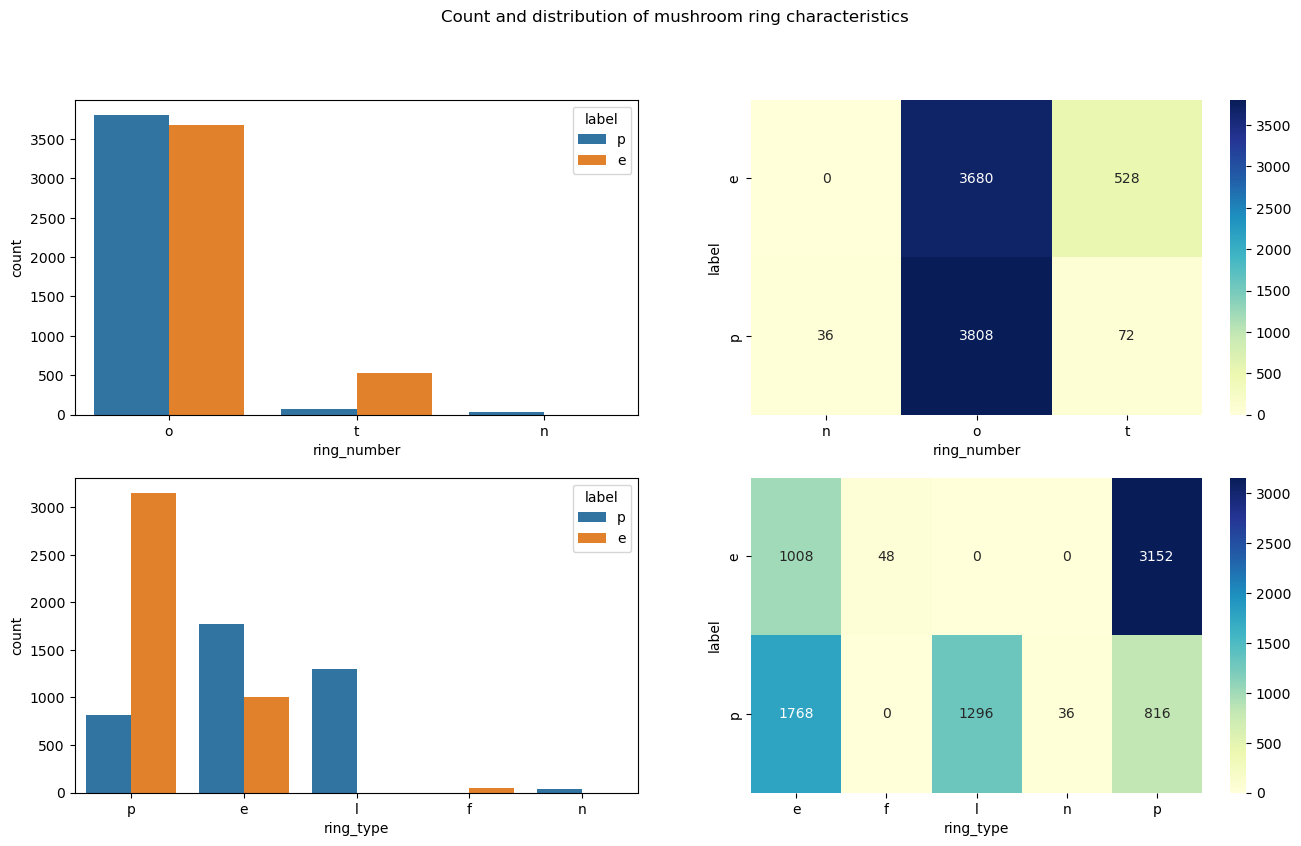

In [27]:
fig, axes = plt.subplots(2, 2, figsize = (16, 9))

sns.countplot(ax = axes[0, 0], data = mushrooms_data, x = 'ring_number', hue = 'label')
sns.heatmap(pd.crosstab(mushrooms_data['label'], mushrooms_data['ring_number']), ax = axes[0, 1], annot = True, fmt = 'd', cmap = 'YlGnBu')
sns.countplot(ax = axes[1, 0], data = mushrooms_data, x = 'ring_type', hue = 'label')
sns.heatmap(pd.crosstab(mushrooms_data['label'], mushrooms_data['ring_type']), ax = axes[1, 1], annot = True, fmt = 'd', cmap = 'YlGnBu')

fig.suptitle('Count and distribution of mushroom ring characteristics')

plt.show()

Most of the mushrooms in the dataset have one("o") ring. They are evenly distributed between the "label" categories. Around 600 have two("t") rings and only 36 don't have a ring.

Ring type characteristic brings more value. All 1296 observations in large("l") category are of poisonous mushrooms. The most frequent category is pendant("p") represents about a half of the reccords and edible label preveil significantly. Flaring("f") and none("n") categories have less than fifty observations.

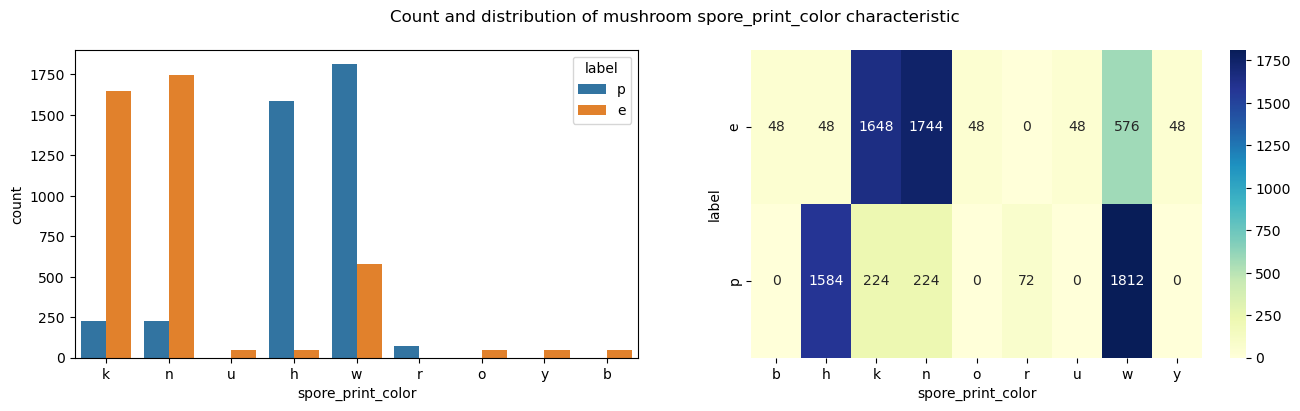

In [28]:
fig, axes = plt.subplots(1, 2, figsize = (16, 4))

sns.countplot(ax = axes[0], data = mushrooms_data, x = 'spore_print_color', hue = 'label')
sns.heatmap(pd.crosstab(mushrooms_data['label'], mushrooms_data['spore_print_color']), ax = axes[1], annot = True, fmt = 'd', cmap = 'YlGnBu')

fig.suptitle('Count and distribution of mushroom spore_print_color characteristic')

plt.show()

Spore print color seems to be another telling feature w.r.t. the classification of poisonous mushrooms. Five of all nine categories have less than 100 records. The other four categories are roughly evenly distributed and in each of them significantly prevails one of the target value labels. Observations with "black"(k) and "brown"(b) spore print color are mostly "edible", while these with "white"(w) and "chocolate"(h) are mostly "poisonous".

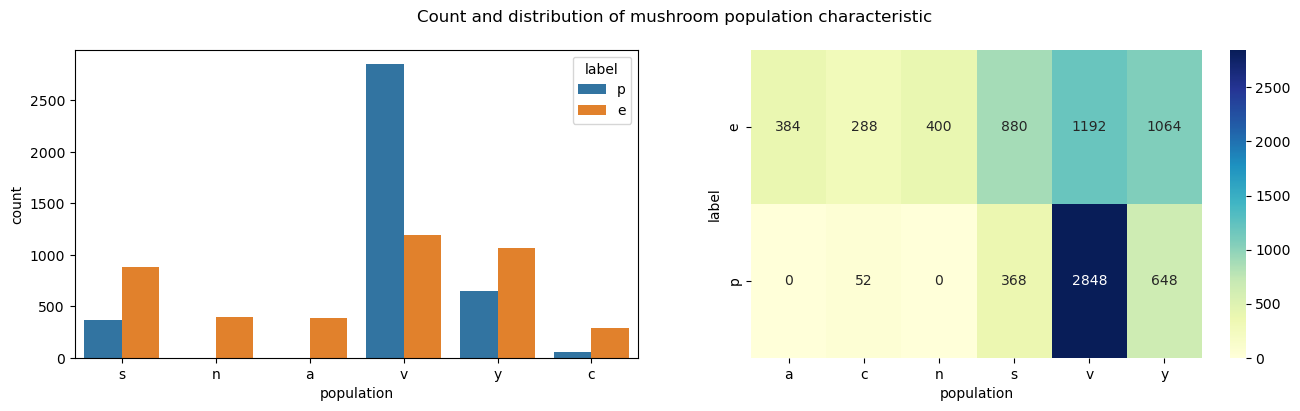

In [29]:
fig, axes = plt.subplots(1, 2, figsize = (16, 4))

sns.countplot(ax = axes[0], data = mushrooms_data, x = 'population', hue = 'label')
sns.heatmap(pd.crosstab(mushrooms_data['label'], mushrooms_data['population']), ax = axes[1], annot = True, fmt = 'd', cmap = 'YlGnBu')

fig.suptitle('Count and distribution of mushroom population characteristic')

plt.show()

There are six categories in "population" feature. The most frequent one is "several"(v). "Abundand"(a) and "numerous"(n) are relatively small in number - around 400, but contain only records of "edible" label. Seems that mushrooms of lepricota and agaricus genera which grow in groups has a greater chance not to be poisonous.

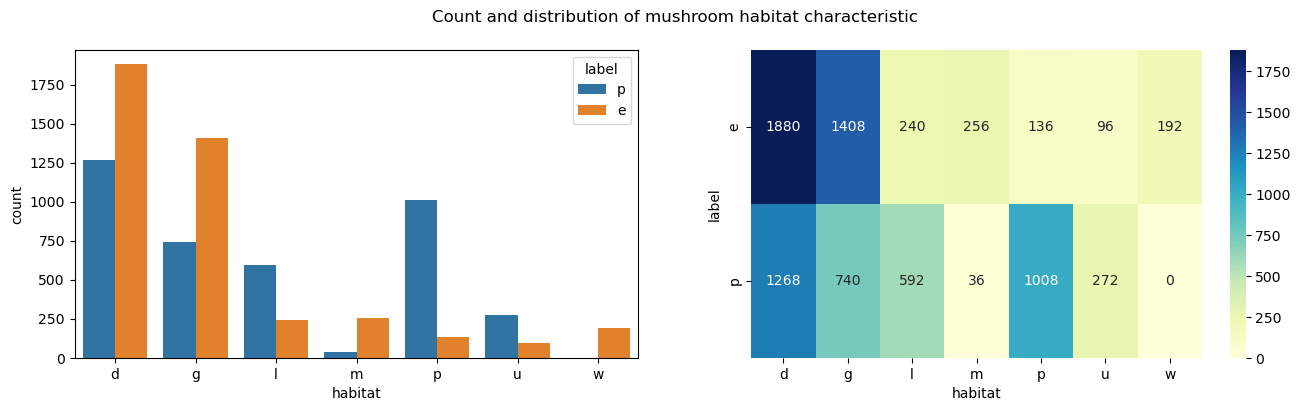

In [30]:
fig, axes = plt.subplots(1, 2, figsize = (16, 4))

sns.countplot(ax = axes[0], data = mushrooms_data, x = 'habitat', hue = 'label', order = ['d', 'g', 'l', 'm', 'p', 'u', 'w'])
sns.heatmap(pd.crosstab(mushrooms_data['label'], mushrooms_data['habitat']), ax = axes[1], annot = True, fmt = 'd', cmap = 'YlGnBu')

fig.suptitle('Count and distribution of mushroom habitat characteristic')

plt.show()

Mushroom samples were collected across seven habitats, most frequent of which are "woods"(d) and "grasses"(g). In the third most frequent category - "paths"(p), most of the records have "poisonous" label.

#### Correlation analysis
Since all features of the dataset are of categorical type, a suitable technique to measure the corelations is needed. One option is to one - hot encode the values first, and then to search for correlations using standard methods for numerical data like Pearson's correlation. One problem with this approach is that the encoding will increase the dimensionality of the dataset and the result will become too complex to analyse. Instead, I will use a Cramér's V as a measure of association between the features. It is based on the "Pearson's chi - square test for independence". The output is normalized value of chi - square statistic ranging between 0(indicating no association) and 1(full association). After Cramér's V is calculated for all pairs of features in the dataset, the results are plotted as a heatmap.

Cramér's V formula:

$$ V = \sqrt{\frac{\chi^2 / n}{\min(k - 1, r - 1)}} $$

Where:

- $ \chi^2 $ is the chi - square statistic
- $ \ n $ is the total number of observations
- $ \ r $ is the number of categories in the first variable
- $ \ k $ is the number of categories in the second variable

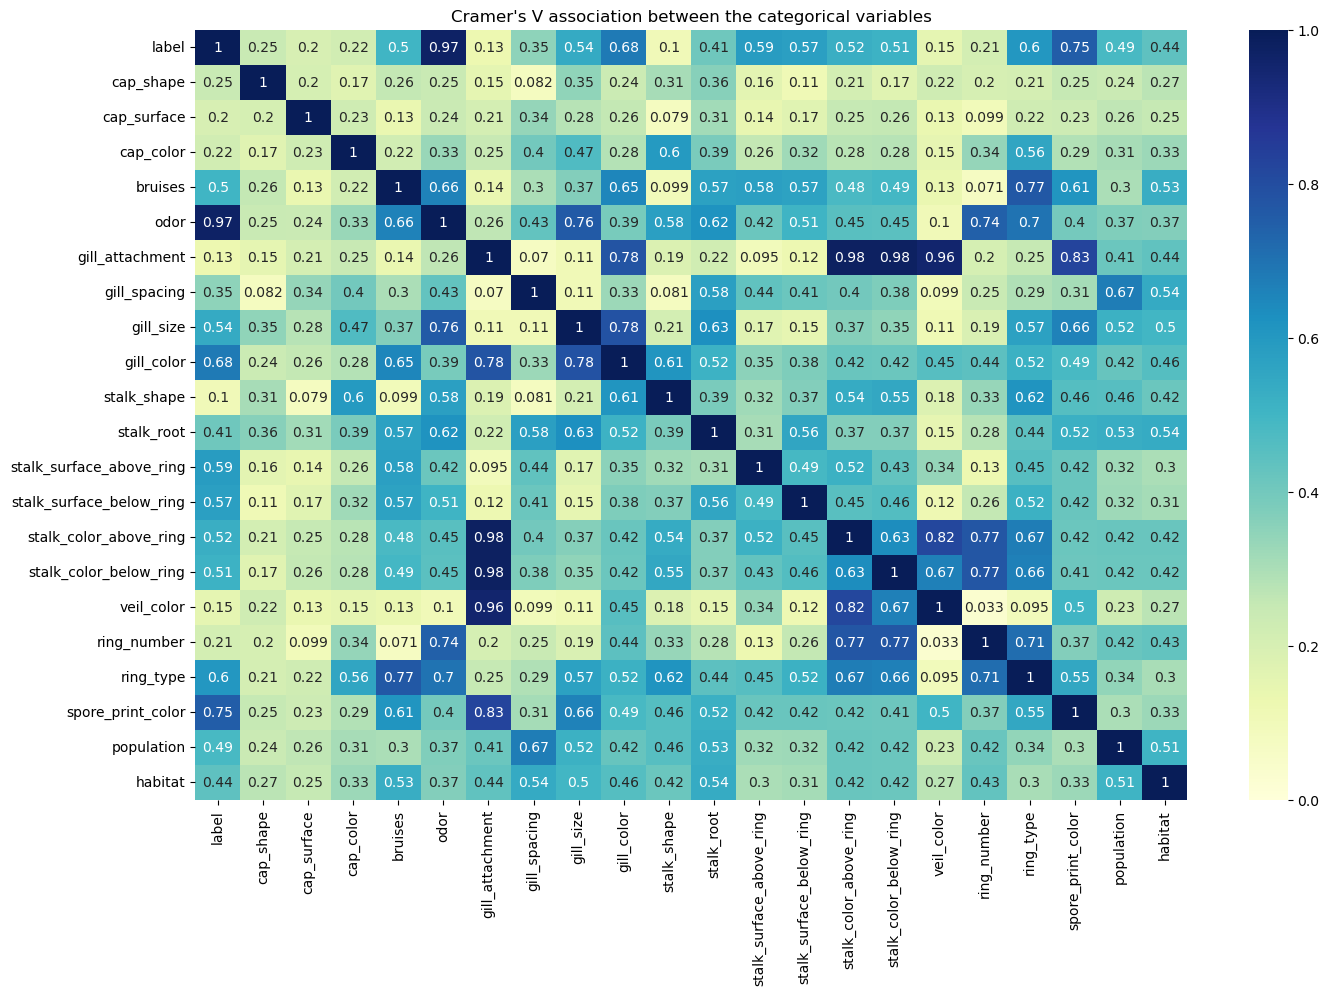

In [31]:
plt.figure(figsize = (16, 10))
sns.heatmap(data = functions.construct_cramers_v_matrix(mushrooms_data), vmin = 0.0, vmax = 1.0, annot = True, cmap = 'YlGnBu')
plt.title('Cramer\'s V association between the categorical variables')
plt.show()

On the countplots above we see that some features carry more information than others. Аs confirmation of these observations, the heatmat clarify that the "odor" feature holds the most valuable information about the target variable. Another very important characteristics seems to be "spore_print_color" and "gill_color". Also there is a noticeable correlation between "gill_attachment" and stalk and veil colors features.

I will separate the data by the most frequent "odor" categories - "none" and "foul" and then observe the frequency distributions of "spore_print_color" categories.

In [32]:
no_odor_samples = mushrooms_data[mushrooms_data['odor'] == 'n']

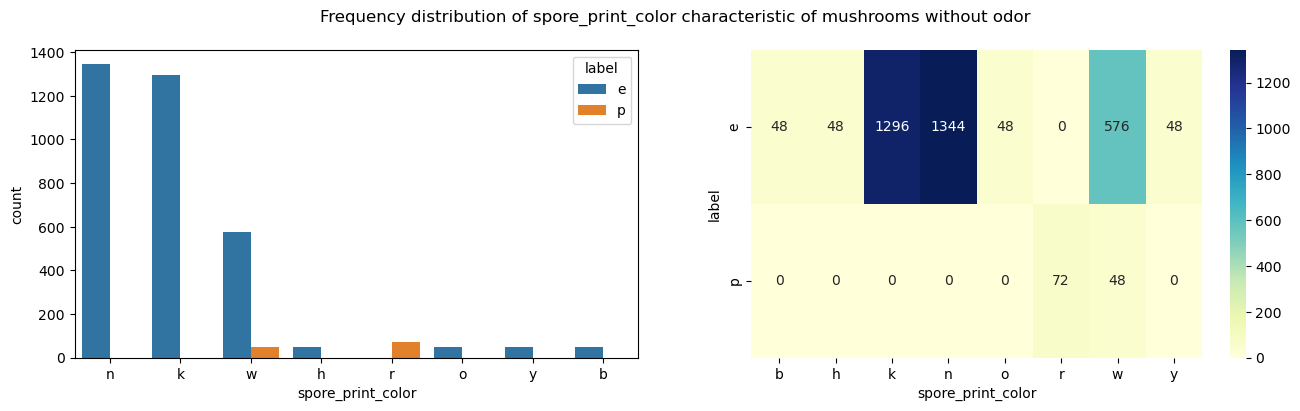

In [33]:
fig, axes = plt.subplots(1, 2, figsize = (16, 4))

sns.countplot(ax = axes[0], data = no_odor_samples, x = 'spore_print_color', hue = 'label')
sns.heatmap(pd.crosstab(no_odor_samples['label'],no_odor_samples['spore_print_color']), ax = axes[1], annot = True, fmt = 'd', cmap = 'YlGnBu')

fig.suptitle('Frequency distribution of spore_print_color characteristic of mushrooms without odor')

plt.show()

In [34]:
foul_odor_samples = mushrooms_data[mushrooms_data['odor'] == 'f']

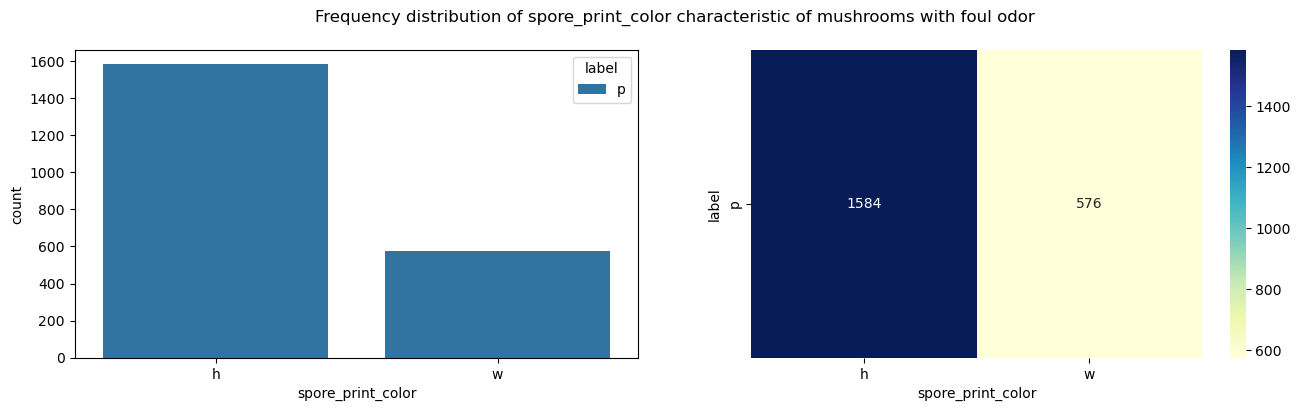

In [35]:
fig, axes = plt.subplots(1, 2, figsize = (16, 4))

sns.countplot(ax = axes[0], data = foul_odor_samples, x = 'spore_print_color', hue = 'label')
sns.heatmap(pd.crosstab(foul_odor_samples['label'],foul_odor_samples['spore_print_color']), ax = axes[1], annot = True, fmt = 'd', cmap = 'YlGnBu')

fig.suptitle('Frequency distribution of spore_print_color characteristic of mushrooms with foul odor')

plt.show()

The plots above show that the "odor" and "spore_print_color" features can determine signifficant part of observations in the data as edible or poisonous. These two mushroom characteristcs would be of great importance to the work of the classification algorithms.

In [36]:
# mushrooms_data.to_csv('data/cleaned_dataset.csv', index = False)

### Methodology

#### Spliting the dataset
Sklearn "train_test_split" method is used to split the data to train and test subsets. It is shuffled before the split and is stratified by the target variable to preserve it's classes proportion. Accordingly to the size of the dataset and the presence of some rare categories, a 75 / 25 split us used to ensure a decent size and quality of the testing set.

In [37]:
mushroom_attributes = mushrooms_data.drop(columns = ['label'])

In [38]:
mushroom_target = mushrooms_data['label']

In [39]:
mushroom_attr_train, mushroom_attr_test, mushroom_target_train, mushroom_target_test = train_test_split(
    mushroom_attributes, mushroom_target, test_size = 0.25, random_state = RANDOM_SEED, stratify = mushroom_target
)

In [40]:
mushroom_attr_train.shape, mushroom_attr_test.shape, mushroom_target_train.shape, mushroom_target_test.shape

((6093, 21), (2031, 21), (6093,), (2031,))

The proportions of target variable have remained the same after the split:

In [41]:
mushrooms_data['label'].value_counts(normalize = True)

label
e    0.517971
p    0.482029
Name: proportion, dtype: float64

In [42]:
mushroom_target_train.value_counts(normalize = True)

label
e    0.517971
p    0.482029
Name: proportion, dtype: float64

In [43]:
mushroom_target_test.value_counts(normalize = True)

label
e    0.517971
p    0.482029
Name: proportion, dtype: float64

#### Encoding
All feature's values have to be encoded from "str" to numerical data type as needed for proper work with ML algorithms. I will use one - hot encoding since the categories within the features are not ranked or hierarchical, thus label encoding would not be appropriate. Because the presence of some rare categhories, handle_unknown = "ignore" and a list which contains all possible categories are provided as arguments to the encoder.

In [44]:
mushroom_columns = mushroom_attr_train.columns.values

In [45]:
mushroom_categories = [mushroom_attr_train[col].unique() for col in mushroom_columns]

In [46]:
attr_encoder = ColumnTransformer(
    transformers = [
        ('one-hot', OneHotEncoder(handle_unknown = 'ignore', categories = mushroom_categories), mushroom_columns)
    ]
)

#### Algorithms

Algorithm selection is based on the applied EDA, characteristics of the dataset and results of previous research. Even with simple algorithms, high values of evaluation metrics have been achieved previously. Indeed, the results of the data analysis showed that some of the features can be of great importance in determining the class of the target variable. At the other hand, the size of the dataset may be not big enough to complex algorithms like XGBoost which are prone to overfitting. Simple classification algorithm like Logistic Regression which can be used initially as a baseline. It's coefficients can be used to distinguish the most signifficant features. Applying Random Forest and SVC could rise the performance(w.r.t the evaluation metric) afterwards if needed. The transformer and the used algorithm are incorporated as a steps of a pipeline, ensuring modularization and reproducibility of the process.

#### Evaluation and hyperparameter tuning
To assess the performance of the models is used stratified k - fold cross - validation technique. This approach is suitable because the dataset is relatively small and do not have enough obervations for separate validation set. For this reasos the training set is randomly divided into 5 folds, ensuring that every data point, including those with rare categories, is used in both training and validation.

To distinguish the toxic mushrooms is of great importance. Labeling a poisonous mushroom as edible can be fatal in the real world. For this reasont I want to ensure that when the model predicts "edible" it is actually edible. The appropriate evaluation metric in this case is **recall**:

$$ Recall = \frac{TP}{TP + FN} $$

It shows what part of all "poisonous" labeled mushrooms was retrieved by the model. I will use it as main evaluation metric to asses the performance of the classification models in the project.

Hyperopt library is used for hyperparameter tuning. Negative recall is set as loss metric for optimization since the algorithm tries to minimize it. In addition, accuracy and area under the ROC metrics are observed. Appropriate search space and objective function is defined for each of the used algorithms.

In [47]:
eval_metrics = {
        'recall': make_scorer(recall_score, pos_label = 'p'),
        'accuracy': make_scorer(accuracy_score),
        'roc_auc': 'roc_auc'
    }

### Logistic Regression

#### Training

Logistic Regression algorithm are initialized with "liblinear" solver, taking into consideration the relatively small size of the dataset, and because of the support of both Lasso and Ridge regularization techniques.

Two hyperparameters are included in the optimization search space. They are "penalty" with two possible values - l1 and l2, and regularization strength "C" which will be tuned between 0.001 and 100. 

In [48]:
logr_search_space = {
    'penalty': hp.choice('penalty', ['l1', 'l2']),
    'C': hp.loguniform('C', np.log(1e-3), np.log(1e2))
}

In [49]:
logr_trials = Trials()

logr_fmin = fmin(
    fn = lambda params: functions.hyperopt_objective(
        params = params,
        classifier = 'LogisticRegression', 
        attr_train = mushroom_attr_train,
        target_train = mushroom_target_train,
        eval_metrics = eval_metrics,
        transformer = attr_encoder,
        random_seed = RANDOM_SEED
    ),
    space = logr_search_space,
    algo = tpe.suggest,
    max_evals = 80,
    trials = logr_trials,
    rstate = np.random.default_rng(RANDOM_SEED)
)

100%|██████████████████████████████████████████████████████████████| 80/80 [00:50<00:00,  1.58trial/s, best loss: -1.0]


In [50]:
logr_fmin

{'C': 68.29736138744246, 'penalty': 1}

Minimization function returns "C" = 68.29736138744246 and 'penalty' = 1(L2) as the best values of hyperparameters.

The relevant information from each trial is extracted and visualized as pandas dataframe.

In [51]:
logr_metrics = []
for trial in logr_trials.trials:
    result = trial['result']
    logr_metrics.append({
        'loss': result['loss'],
        'mean_recall': result['other_metrics']['mean_recall'],
        'std_recall': result['other_metrics']['std_recall'],
        'mean_accuracy': result['other_metrics']['mean_accuracy'],
        'std_accuracy': result['other_metrics']['std_accuracy'],
        'mean_roc_auc': result['other_metrics']['mean_roc_auc'],
        'std_roc_auc': result['other_metrics']['std_roc_auc'],
        'params': trial['misc']['vals']
    })

logr_trials_df = pd.DataFrame(logr_metrics)

In [52]:
logr_trials_df

,loss,mean_recall,std_recall,mean_accuracy,std_accuracy,mean_roc_auc,std_roc_auc,params
0,-0.995574,0.995574,0.002310,0.997866,0.001113,0.999953,3.063276e-05,"{'C': [0.09375928061459672], 'penalty': [1]}"
1,-1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000e+00,"{'C': [68.29736138744246], 'penalty': [1]}"
2,-1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,4.965068e-17,"{'C': [7.951969983018893], 'penalty': [0]}"
3,-1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,7.021667e-17,"{'C': [4.220650205931255], 'penalty': [0]}"
4,-0.965613,0.965613,0.004971,0.974396,0.005433,0.996803,1.361914e-03,"{'C': [0.004064644237754485], 'penalty': [1]}"
...,...,...,...,...,...,...,...,...
75,-0.997957,0.997957,0.001274,0.999015,0.000614,0.999989,9.716552e-06,"{'C': [0.15577941981187796], 'penalty': [1]}"
76,-1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000e+00,"{'C': [16.785735046250956], 'penalty': [1]}"
77,-1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000e+00,"{'C': [23.29286159258232], 'penalty': [1]}"
78,-1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000e+00,"{'C': [8.806770443443561], 'penalty': [1]}"


There are many combinations of hyperparameters which result in maximum value for the evaluation metrics. This may be sign of overfitting. To confirm whether it is occurring, the model will be evaluated on the test set. I suggest that the high values of the evaluation metrics ​​are due to the relatively small size of the dataset, balanced distribution of the target variable with easily separable classes, and presence of clear patterns in the data. The standard deviation of the cross - validation metrics indicates low variability and consistency in results across diferent folds.

#### Model selection

From the trials with perfect score the combination of hyperparameters with the highest regularization strength among these using L1 penalty, is choosen. Since the results of EDA suggest that some features have low significance w.r.t the task of predicting the target variable label, Lasso is applied to sieve only the significant ones. Pushing the coefficients of the less important features to zero will have the effect of feature selection. Since the modelling produces high scores of evaluation metrics, regularization strength is chosen to be of maximum value(among the trials with L1 penalty) to reduce eventual overfitting.

In [53]:
logr_best_trial = logr_trials_df.sort_values(
    by = ['params'], 
    key = lambda col: col.apply(lambda x: (x['penalty'][0], x['C'][0]))
).sort_values(
    by = ['mean_recall', 'mean_accuracy', 'mean_roc_auc'], 
    ascending = False
).head(5)

In [54]:
logr_best_trial.head(1)

,loss,mean_recall,std_recall,mean_accuracy,std_accuracy,mean_roc_auc,std_roc_auc,params
59,-1.0,1.0,0.0,1.0,0.0,1.0,0.0,"{'C': [0.8859574659241594], 'penalty': [0]}"


In [55]:
logr_c = logr_best_trial['params'].values[0]['C'][0]
logr_c

0.8859574659241594

In [56]:
logr_penalty = 'l1'

In [57]:
logr_model = LogisticRegression(penalty = logr_penalty, C = logr_c, solver = 'liblinear', random_state = RANDOM_SEED)

In [58]:
logr_pipe = Pipeline(steps = [
    ('encode', attr_encoder),
    ('classifier', logr_model)
])

In [59]:
logr_pipe.fit(mushroom_attr_train, mushroom_target_train)

Pipeline(steps=[('encode',
                 ColumnTransformer(transformers=[('one-hot',
                                                  OneHotEncoder(categories=[array(['x', 'f', 'b', 'k', 's', 'c'], dtype=object),
                                                                            array(['s', 'y', 'f', 'g'], dtype=object),
                                                                            array(['w', 'n', 'b', 'y', 'g', 'u', 'e', 'p', 'c', 'r'], dtype=object),
                                                                            array(['f', 't'], dtype=object),
                                                                            array(['n', 'f', 'y', 's', 'l', 'p', 'c', 'a', 'm'], dtype=object),
                                                                            array(['f', 'a'], dtype...
       'gill_attachment', 'gill_spacing', 'gill_size', 'gill_color',
       'stalk_shape', 'stalk_root', 'stalk_surface_above_ring',
       'stalk_surface_below_ring', 'stalk_color_above_ring',
       'stalk_color_below_ring', 'veil_color', 'ring_number', 'ring_type',
       'spore_print_color', 'population', 'habitat'], dtype=object))])),
                ('classifier',
                 LogisticRegression(C=0.8859574659241594, penalty='l1',
                                    random_state=11, solver='liblinear'))])

#### Feature and category importance

In [60]:
logr_coefficients = logr_pipe.named_steps['classifier'].coef_[0]

In [61]:
logr_encoded_feature_names = logr_pipe.named_steps['encode'].named_transformers_['one-hot'].get_feature_names_out(mushroom_columns)

In [62]:
len(logr_coefficients) == len(logr_encoded_feature_names)

True

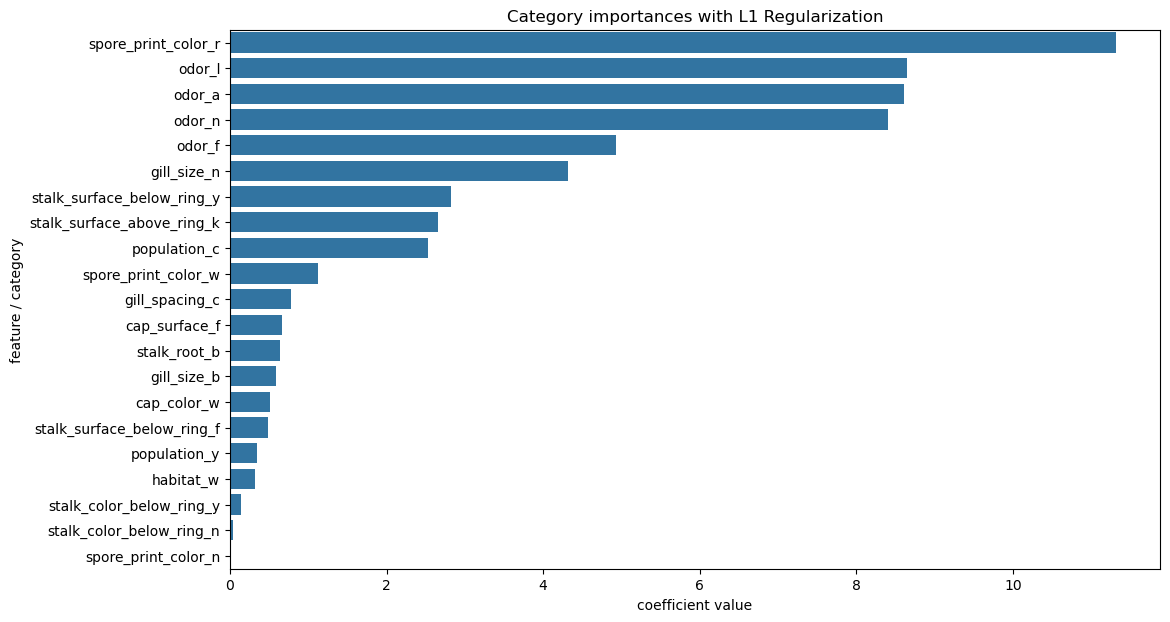

In [63]:
logr_cat_coef_df = pd.DataFrame({'features': logr_encoded_feature_names, 'coefficients': logr_coefficients})
logr_cat_coef_df['abs_coefficients'] = logr_cat_coef_df['coefficients'].abs()
logr_cat_coef_df = logr_cat_coef_df[logr_cat_coef_df['coefficients'] != 0]
logr_cat_coef_df = logr_cat_coef_df.sort_values(by = 'abs_coefficients', ascending = False)

plt.figure(figsize = (12, 7))
sns.barplot(x = 'abs_coefficients', y = 'features', data = logr_cat_coef_df)
plt.xlabel('coefficient value')
plt.ylabel('feature / category')
plt.title('Category importances with L1 Regularization')
plt.show()

Since the features have been one - hot encoded, the solver find separate coefficients for each category. These coefficients show how each specific category influences the probability of predicting the positive class. Of course, they are shrаnk by the regularization term and some are completely gone, because L1 regularization is applied. 

We can observe that the most significant category is "spore_print_color_r" which corresponds to green color os spores. The EDA above shows that there are 78 observations containing this category, and all of them are of poisonous mushrooms. For the same feature the algorithm found as less signifficant the "white"(w) and "numerous"(n) categories. Тhe absence of other categories that EDA defined as significant, within "spore_print_color" feature, like "black"(k) and "chocolate"(h) is noticeable. It is due to the used L1 regularization.

The next most significant categories belong to "odor" feature. As noted in EDA, this column seems to be the most important for the classification of the target variable label. Still some of it's categories which contain only observations with no mixed labels, are penalized by the Lasso to values of zero. Generally, from all 116 categories just 21 are left.

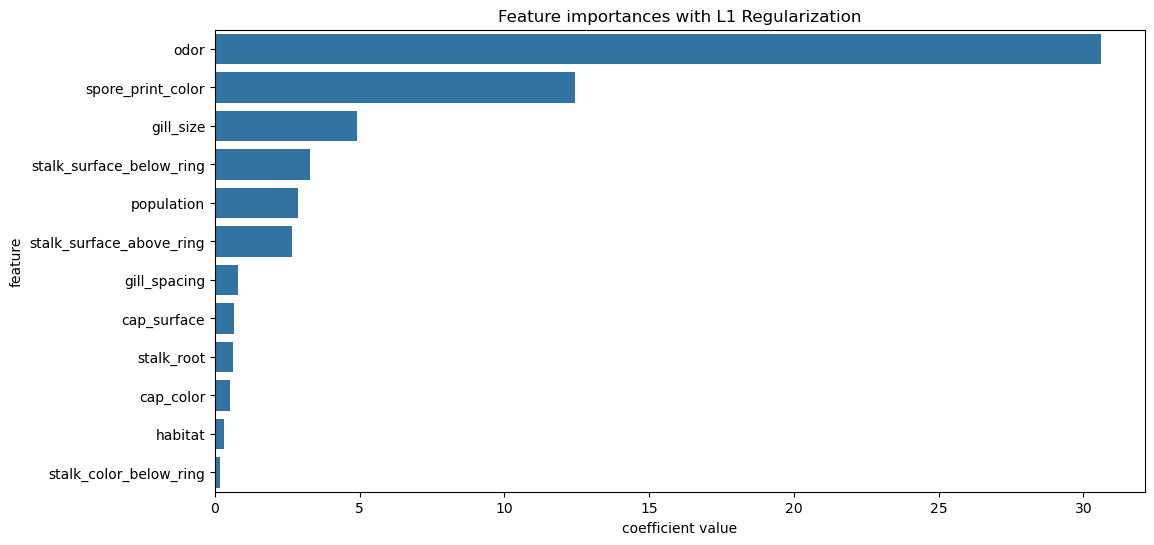

In [64]:
logr_cat_coef_df['original_features'] = logr_cat_coef_df['features'].apply(lambda name: name.rsplit('_', 1)[0])

feature_importance_df = logr_cat_coef_df.groupby('original_features')['abs_coefficients'].sum().reset_index()
feature_importance_df = feature_importance_df.sort_values(by = 'abs_coefficients', ascending = False)

plt.figure(figsize = (12, 6))
sns.barplot(x = 'abs_coefficients', y = 'original_features', data = feature_importance_df)
plt.xlabel('coefficient value')
plt.ylabel('feature')
plt.title('Feature importances with L1 Regularization')
plt.show()

To interpret the importance of original features, the one-hot encoded coefficients are grouped. Like in the EDA insights, the most telling feature determined by the solver is "odor", followed by "spore_print_color". It is noticeable the absence of another very telling(based on data analysis) feature - "gill_color". With that exception, all signifficant features, found in EDA have coefficients greater than zero. Their magnitude(absolute value) indicates the strength of the influence of the corresponding feature. From 21 columns, 12 are left after the applied Lasso regularization.

#### Evaluation with test data

The trained model is evaluated on a test set to assess how well it generalizes to new, unseen data, including some real world scenarios. This should provide an unbiased estimate of the model performance and could detect overfitting. Two types of predictions of target variable class are made and observed - of labels and of probabilities.

In [65]:
logr_predicted = logr_pipe.predict(mushroom_attr_test)

In [66]:
logr_prob = logr_pipe.predict_proba(mushroom_attr_test)

In [67]:
logr_conf_matrix = confusion_matrix(mushroom_target_test, logr_predicted)

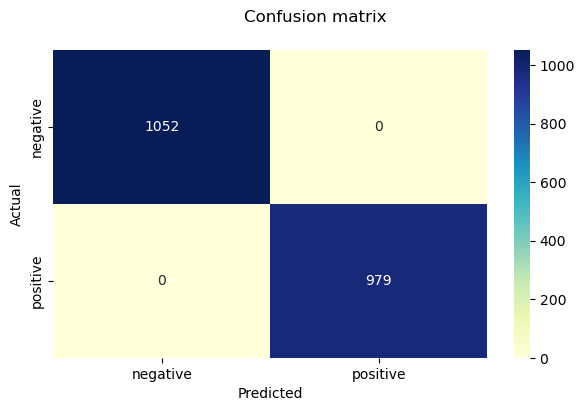

In [68]:
fig, axes = plt.subplots(1, 1, figsize = (7, 4))

sns.heatmap(logr_conf_matrix, annot = True, fmt = 'd', cmap = 'YlGnBu')

axes.set_xlabel('Predicted')
axes.set_ylabel('Actual')
axes.xaxis.set_ticklabels(['negative', 'positive'])
axes.yaxis.set_ticklabels(['negative', 'positive'])
fig.suptitle('Confusion matrix')

plt.show()

The confusion matrix shows that all predictions of test data labels made by the model are correct. This is an indication that the model does not overfitting and generalize well, at least on the test data. Since the evaluation metrics are derivatives of the confusion matrix, it can be concluded that they will have a perfect score. They are calculated and compared with the mean evaluation metric scores achieved during the training of the model.

In [69]:
compared_metrics = {
    'metric': ['recall', 'accuracy', 'roc_auc'],
    'cross_validation': [logr_trials_df['mean_recall'].mean(), logr_trials_df['mean_accuracy'].mean(), logr_trials_df['mean_roc_auc'].mean()],
    'test_set': [recall_score(mushroom_target_test, logr_predicted, pos_label = 'p'), accuracy_score(mushroom_target_test, logr_predicted), roc_auc_score(mushroom_target_test, logr_prob[:, 1])]
}

comapared_metrics_df = pd.DataFrame(compared_metrics)
comapared_metrics_df = comapared_metrics_df.melt(id_vars = 'metric', var_name = 'evaluation', value_name = 'score')

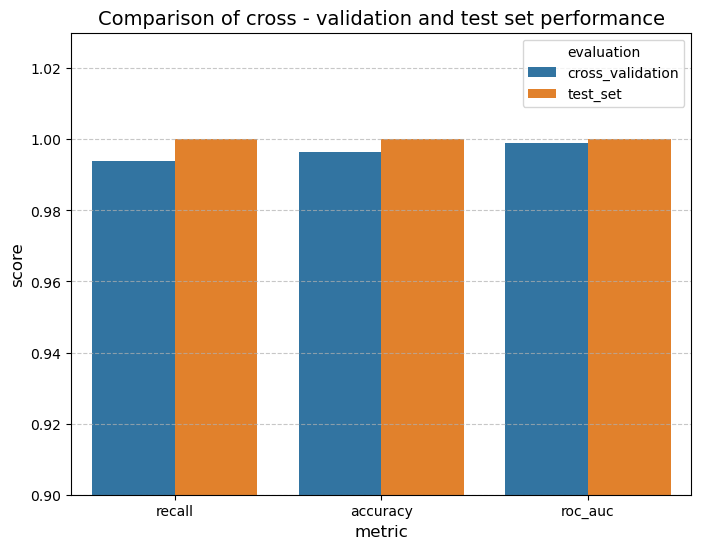

In [70]:
plt.figure(figsize = (8, 6))
sns.barplot(data = comapared_metrics_df, x = 'metric', y = 'score', hue = 'evaluation')

plt.title('Comparison of cross - validation and test set performance', fontsize = 14)
plt.ylim(0.9, 1.03)
plt.ylabel('score', fontsize = 12)
plt.xlabel('metric', fontsize = 12)
plt.grid(axis= 'y', linestyle = '--', alpha = 0.7)

plt.show()

As espexted from the observation of the confusion matrix, all three evaluation metrics have a socre of 1.0. They are equal compared to the cross - validation metrics of the selected model, which also are perfect. The plot above shows that the differences with the mean evaluation scores, achieved during the training of the model, are very small, close to the standard deviations observed in the tuning trials.

These results confirm that the high scores achieved during cross - validation are not a result of overfitting. The selected model performs equally on train and unseen data. It can be concluded that the test data is an good representation of the train data.

In [71]:
mushroom_target_test.value_counts()

label
e    1052
p     979
Name: count, dtype: int64

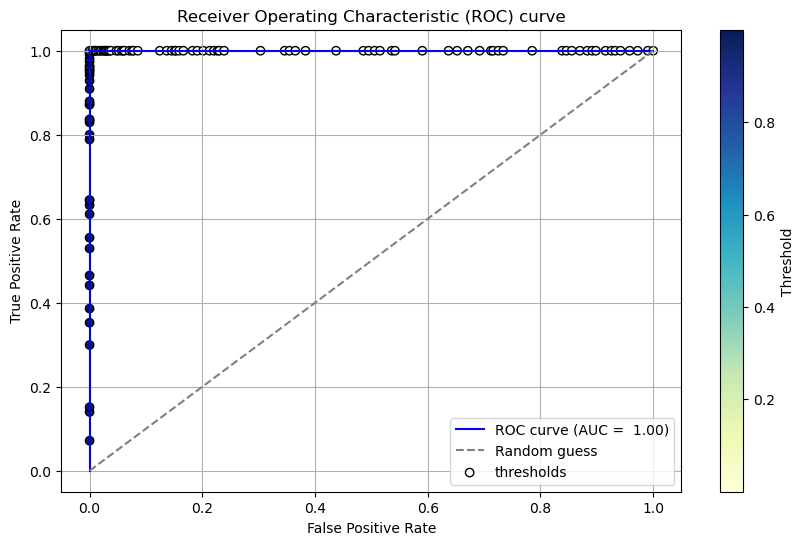

In [72]:
logr_false_pos_rate, logr_true_pos_rate, thresholds = roc_curve(mushroom_target_test, logr_prob[:, 1], pos_label = 'p')

logr_test_roc_auc = roc_auc_score(mushroom_target_test, logr_prob[:, 1])

plt.figure(figsize = (10, 6))
plt.plot(logr_false_pos_rate, logr_true_pos_rate, label = f'ROC curve (AUC = {logr_test_roc_auc: .2f})', color = 'blue')
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'gray', label = 'Random guess')
plt.scatter(logr_false_pos_rate, logr_true_pos_rate, c = thresholds, cmap = 'YlGnBu', label = 'thresholds', edgecolors = 'k')
plt.colorbar(label = 'Threshold')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

Receiver Operating Characteristic curve represents the performance of the model at different classification thresholds. It plots the possible True Positive rates against the False Positive ones. ROC curve AUC score summarizes the mode's performance across all possible classification thresholds and is equal to the area under the ROC curve. Since the model makes perfec predictions on the test data, the AUC is 1 and the performance remains constantly perfect on all thresholds.

In order to evaluate the model's performance in different important and real world cases, the test data is filtered and splitted below on several subsets.

Below the model is tested on subset of the test data, where the predictted probabilities of the positive class are very high. This is a subset with only poisonous observations. The perfect results of this evaluation confirms that the model is highly confident in its classifications.

In [73]:
high_confidence_attr_test = mushroom_attr_test[(logr_prob[:, 1] > 0.95)]
high_confidence_target_test = mushroom_target_test[(logr_prob[:, 1] > 0.95)]
logr_high_conf_pred = logr_pipe.predict(high_confidence_attr_test)

In [74]:
recall_score(high_confidence_target_test, logr_high_conf_pred, pos_label = 'p')

1.0

The test data is filtered to a subset where the predicted probabilities are relatively close to the threshold of 0.5. It is noticeable that there are only two observations where the model shows even a small uncertainty.

In [75]:
low_confidence_reccords = mushroom_attr_test[(logr_prob[:, 1] > 0.3) & (logr_prob[:, 1] < 0.7)]
low_confidence_reccords

,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,stalk_shape,stalk_root,stalk_surface_above_ring,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_color,ring_number,ring_type,spore_print_color,population,habitat
4364,b,y,w,t,n,f,w,n,w,e,b,s,s,w,w,w,o,p,w,c,l
5107,f,g,w,t,n,f,w,n,w,e,b,s,s,w,w,w,o,p,w,c,l


In the real world, if the model is used in cultivation industry to ensure the abscence of accidentally existing toxic mushrooms, usually the samples will contain zero or very small percentage positive probes. To check the performance in such situations, the test data is splitted on a subset of only edible observations and another, containing only one percent positive samples. 

In [76]:
imbalanced_mushroom_test = pd.concat([mushroom_attr_test, mushroom_target_test], axis = 1).sort_values(by = 'label').head(1070)

In [77]:
imbalanced_mushroom_test = imbalanced_mushroom_test.sample(frac = 1, random_state = RANDOM_SEED)

In [78]:
imbalanced_mushroom_test['label'].value_counts(normalize = True) * 100

label
e    98.317757
p     1.682243
Name: proportion, dtype: float64

In [79]:
imbalanced_mushroom_attr = imbalanced_mushroom_test.drop(columns = ['label'])

In [80]:
imbalanced_mushroom_target = imbalanced_mushroom_test['label']

In [81]:
logr_imbalanced_prediction = logr_pipe.predict(imbalanced_mushroom_attr)

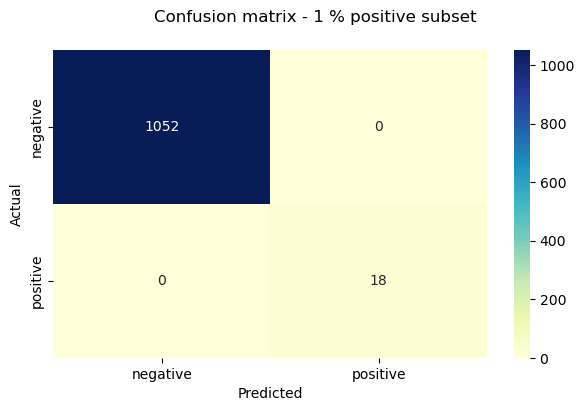

In [82]:
fig, axes = plt.subplots(1, 1, figsize = (7, 4))

sns.heatmap(confusion_matrix(imbalanced_mushroom_target, logr_imbalanced_prediction), annot = True, fmt = 'd', cmap = 'YlGnBu')

axes.set_xlabel('Predicted')
axes.set_ylabel('Actual')
axes.xaxis.set_ticklabels(['negative', 'positive'])
axes.yaxis.set_ticklabels(['negative', 'positive'])
fig.suptitle('Confusion matrix - 1 % positive subset')

plt.show()

In [83]:
zero_positive_attr = mushroom_attr_test[mushroom_target_test == 'e']
zero_positive_target = mushroom_target_test[mushroom_target_test == 'e']

In [84]:
len(zero_positive_attr) == len(zero_positive_target)

True

In [85]:
logr_zero_positive_prediction = logr_pipe.predict(zero_positive_attr)

In [86]:
accuracy_score(zero_positive_target, logr_zero_positive_prediction)

1.0

The model performs without mistakes on the subset containing only observations of edible class as well on the subset with only several positive class reccords. This way is tested how well it generalize on possible real world scenarios.

#### Summary of the experiment and analysis of the result
To solve the task of identification of toxic mushrooms by certain characteristics, a Logistic Regression algorithm was used. Stratified k - fold cross validation and optimization with Hyperopt were appllied in order to find the best performing models. Many of them achieved perfect scores of the evaluation metrics. A model with Lasso "penalty" and inverse regularization strength "C" equal to 0.885 was selected. It was fitted on the whole transformed training set in a pipeline. Afterwards, the model was evaluated on unseen data using separted test set. The global performance, calculated on the whole test set, as well as special case performances was evaluated with perfect scores of the metrics. Feature importance analysis was applied using the coefficients of regression. The results confirmed the insights of the EDA, highlighting "odor" and "spore_print_color" as the most important features.

Тhe chosen data modeling approach led to perfect experimental results. For the main evaluation metric, recall, as well the other used metrics, were achieved scores of 1.0 during the training and when testing the selected model on unseen data. Тhese results suggest that a good biass - variance tradeoff is achieved. To a large extent, this very high results are due to the size and quality of the data. The relatively small datset size of 8124 records allowed even a simple algorithm like Logistic Regression to effectively solve the classification task. If the dataset size was bigger, thus providing more observations for training and testing, probably the results would have been lower. At the other had, the features have provided meaningfull information for the relationships and patterns inside the data. All these factors contribute to the achieved results. The obtained performance(w.r.t the evaluation metrics) are higher compared to some of the past studies on the topic, although they used more complex algorithms. This is mainly due to the inappropriate encoding or lack of hyperparameter tuning in them.

### Conclusion

The results of the experiments in the study confirms some important assumption on the topic:
1. Some of the mushroom's characteristics, describing their smell, spore, cap, stalk and gill, can contribute to the distinction between the edible and poisonous clases, without explicitly determination of the species.

2. The data which describe certain fungi species can be modelled using classification ML algorithms to learn patterns and relationships between the features.

3. Even simple algorithms like Logistic Regression, if accurately trained, can provide very efficient models with respect to the task and the data.


The ML algorithms could find practical application to determine the edibility of the fungi via Computer Vision methods. Тhis process would involve a camera to catch and measure the found in this study important characteristics of the mushrooms.

Of course, the research could be expanded using more data. Тhis would make the classification task more difficult, which would involve the use of more complex ML algorithms like SVM or Ensembles. 

<a id='references'></a>

## References
1. [Mushroom database - info file](../data/agaricus-lepiota.names)
2. [Agaricus genus mushrooms - Wikipedia](https://en.wikipedia.org/wiki/Agaricus)
3. [Lepiota genus mushrooms - Wikipedia](https://en.wikipedia.org/wiki/Lepiota)
4. [Deep learning model for classification of poisonous and edible mushrooms](https://www.mdpi.com/2076-3417/12/7/3409)
5. [Classification of mushroom using ML](../data/mushroom_ml_classification_1.pdf)
6. [Classification of poisonous and edible mushrooms with optimized classification algorithms](../data/mushroom_ml_classification_2.pdf)
7. [Comparative study of machine learning techniques to classify poisonous mushrooms](../data/mushroom_ml_classification_3.pdf)
8. [Kaggle - Mushroom classification](https://www.kaggle.com/datasets/uciml/mushroom-classification/code?datasetId=478&sortBy=commentCount&language=Python)
9. [Mushroom Dataset. (1981). UCI Machine Learning Repository.](https://archive.ics.uci.edu/dataset/73/mushroom)